In [1]:
import torch
import random
from torch import nn, optim
import math
from IPython import display

from res.plot_lib import plot_data, plot_model, set_default

set_default()

In [2]:
# constants
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-3
LAMBDA_L2 = 1e-5
EPOCH = 3000

### Create Synthetic Data

In [3]:
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
N = 1000  # num_samples_per_class
D = 2  # dimensions
C = 3  # num_classes
H = 100  # num_hidden_units


In [4]:
X = torch.zeros(N * C, D).to(DEVICE)
y = torch.zeros(N * C, dtype=torch.long).to(DEVICE)
for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N)
    # When c = 0 and t = 0: start of linspace
    # When c = 0 and t = 1: end of linpace
    # This inner_var is for the formula inside sin() and cos() like sin(inner_var) and cos(inner_Var)
    inner_var = torch.linspace(
        # When t = 0
        (2 * math.pi / C) * (c),
        # When t = 1
        (2 * math.pi / C) * (2 + c),
        N
    ) + torch.randn(N) * 0.2
    
    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * torch.FloatTensor((
            math.sin(inner_var[index]), math.cos(inner_var[index])
        ))
        y[ix] = c
        index += 1

print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

Shapes:
X: (3000, 2)
y: (3000,)


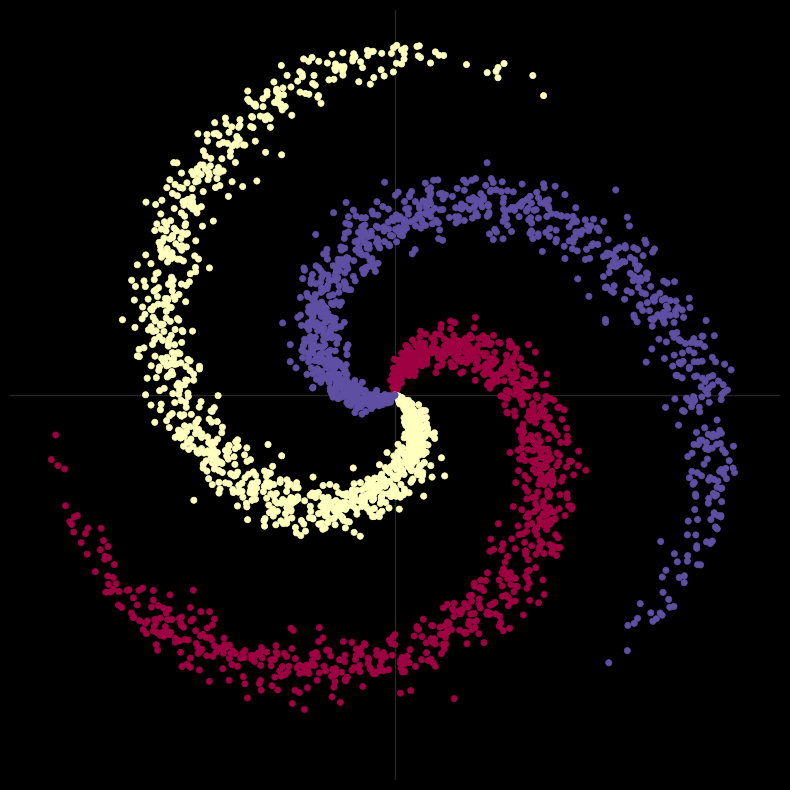

In [5]:
plot_data(X, y)

### Calculate PCA

In [6]:
# Compute mean
mean_x = torch.mean(X, 0)
Xu = X - mean_x

In [7]:
# Compute eigenvectors of the data covariance
S = torch.cov(X.T)
U, _, V = torch.linalg.svd(S)

In [8]:
# Projection to the feature space
Z = torch.matmul(Xu, U[:, 0])

In [9]:
H = torch.vstack((Z, torch.zeros(N*C))).T

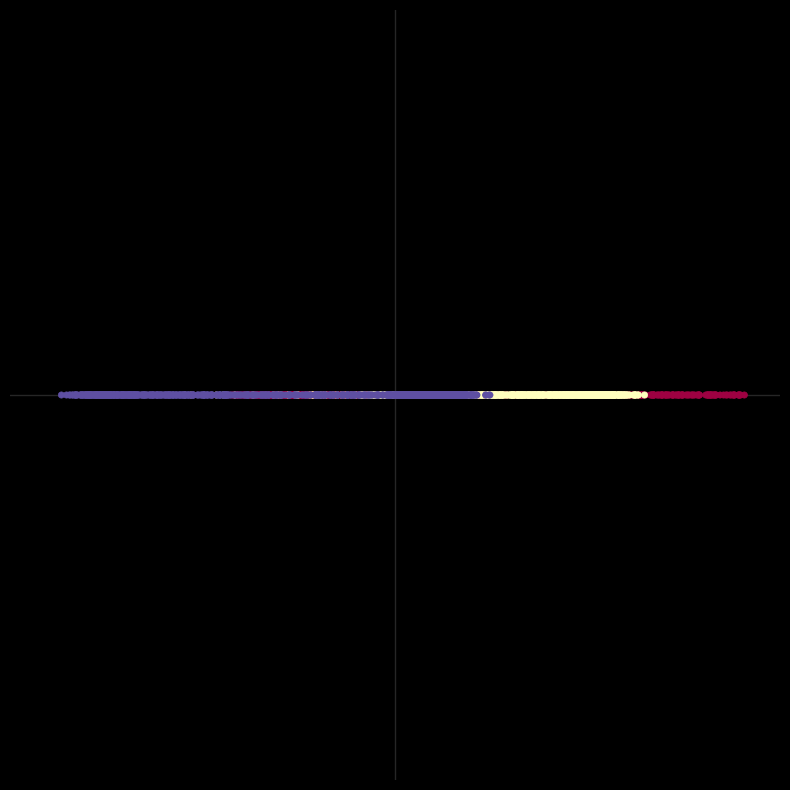

In [10]:
plot_data(H, y)

### Autoencoder

In [11]:
class MLPAutoEnc(nn.Module):
    def __init__(self, d_in=28*28, d_z=100):
        super(MLPAutoEnc, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(d_in, d_z),
            nn.ReLU(),
            nn.Linear(d_z, d_z),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(d_z, d_z),
            nn.ReLU(),
            nn.Linear(d_z, d_in)
        )
        
    def forward(self, x):
        z = self.encoder(x)
        xr = self.decoder(z)
        return xr

In [12]:
# 1. define model
model_nn = MLPAutoEnc(d_in=D, d_z=2)
model_nn.to(DEVICE)
print(model_nn)

MLPAutoEnc(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=2, bias=True)
  )
)


In [13]:
# 2. define loss function and optimizer
loss_nn = nn.MSELoss()
opt_nn = optim.Adam(
    model_nn.parameters(),
    lr=LEARNING_RATE,
    weight_decay=LAMBDA_L2
)

In [14]:
# 3. learning algorithm
for t in range(EPOCH):
    # forward prop
    Xr = model_nn(X)
    
    loss = loss_nn(Xr, X)
    
    print(f"[EPOCH] : {t}/{EPOCH} -- Loss: {loss.item()}")
    display.clear_output(wait=True)
    
    # zero gradient
    opt_nn.zero_grad()
    
    # backprop
    loss.backward() # gradient computation
    opt_nn.step() # parameter update

[EPOCH] : 2999/3000 -- Loss: 0.08441083133220673


In [15]:
with torch.no_grad():
    Z = model_nn.encoder(X)
# H = torch.vstack((Z.flatten(), torch.zeros(N*C))).T

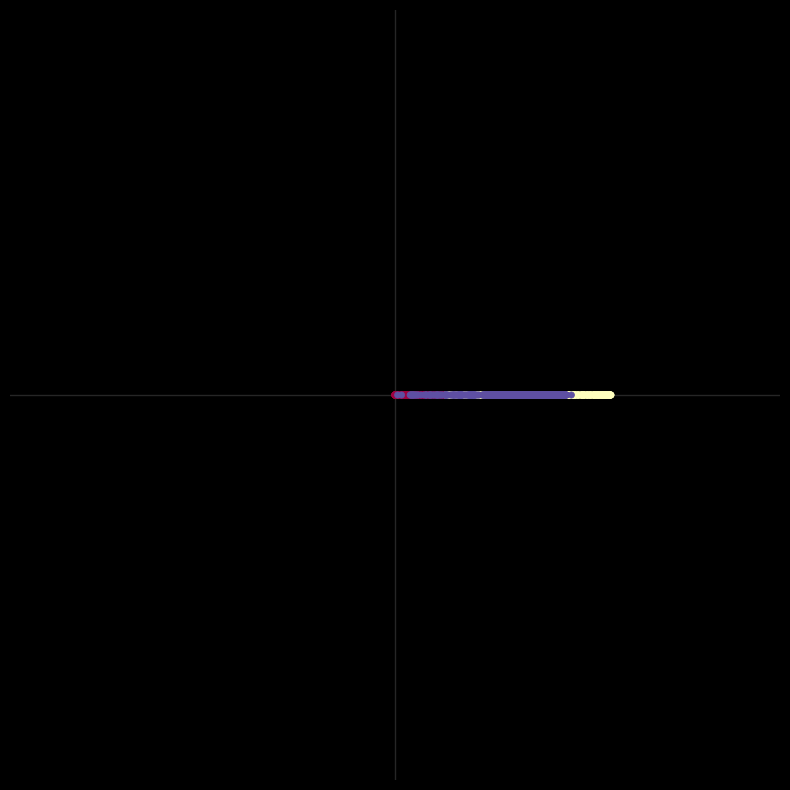

In [16]:
plot_data(Z, y)